# **Customer Segmentation with RFM Analysis**

**Task 3 – Elevvo Pathways**

In this project, we explore customer segmentation using RFM analysis on the famous Online Retail dataset.
The goal is to understand customer behavior and divide them into meaningful groups for better business strategies.

**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


**Step 2: Load and Inspect Dataset**

In [5]:


# Load dataset
df = pd.read_excel(r"C:/Users/PMLS/OneDrive/Desktop/datasets/Online Retail.xlsx")

# Preview
print("Shape:", df.shape)
df.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Step 3: Data Cleaning**

Before analysis, we need to:
* Remove missing CustomerID
* Remove canceled orders (InvoiceNo starting with 'C')
* Keep only positive Quantity and UnitPrice

In [6]:
# Drop rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove canceled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Keep only positive values
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Shape after cleaning:", df.shape)
df.head()


Shape after cleaning: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


* Missing CustomerID rows were dropped because they prevent customer-level analysis.
* Canceled orders (invoices starting with "C") were removed.
* Negative or zero quantities/prices were excluded to ensure data validity.
* A new column TotalPrice was created to measure transaction value.

This step ensures our RFM analysis is accurate.

**Step 4: Create RFM Metrics**

* Recency: Days since last purchase
* Frequency: Number of transactions
* Monetary: Total spending

In [7]:
# Snapshot date (1 day after last transaction)
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.rename(columns={'InvoiceDate':'Recency',
                    'InvoiceNo':'Frequency',
                    'TotalPrice':'Monetary'}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


**Step 5: RFM Scoring**

We’ll assign scores from 1 (low) to 5 (high) for each RFM metric.

In [8]:
# Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Combine into RFM Segment and Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,5,115,7
1,12347.0,2,7,4310.00,5,5,5,555,15
2,12348.0,75,4,1797.24,2,4,4,244,10
3,12349.0,19,1,1757.55,4,1,4,414,9
4,12350.0,310,1,334.40,1,1,2,112,4


* Each metric is divided into 5 quantiles (1 = low, 5 = high).
* Customers with low Recency (recent buyers) get higher R scores.
* Frequent buyers get higher F scores.
* Big spenders get higher M scores.

The combined RFM_Score (3–15) helps us identify overall customer value.

**Step 6: Define Customer Segments**

In [9]:
def segment_me(score):
    if score >= 13: return "Champions"
    elif score >= 10: return "Loyal Customers"
    elif score >= 7: return "Potential Loyalists"
    else: return "At Risk"

rfm['Segment'] = rfm['RFM_Score'].apply(segment_me)

rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean',
    'CustomerID':'count'
}).rename(columns={'CustomerID':'Count'})


,Recency,Frequency,Monetary,Count
Segment,,,,
At Risk,192.268405,1.136503,279.776688,1304
Champions,14.614561,11.739829,6697.362452,934
Loyal Customers,43.420635,3.860119,1397.450309,1008
Potential Loyalists,85.427656,2.009158,808.253353,1092


**Step 7: Visualization**

Distribution of R, F, M

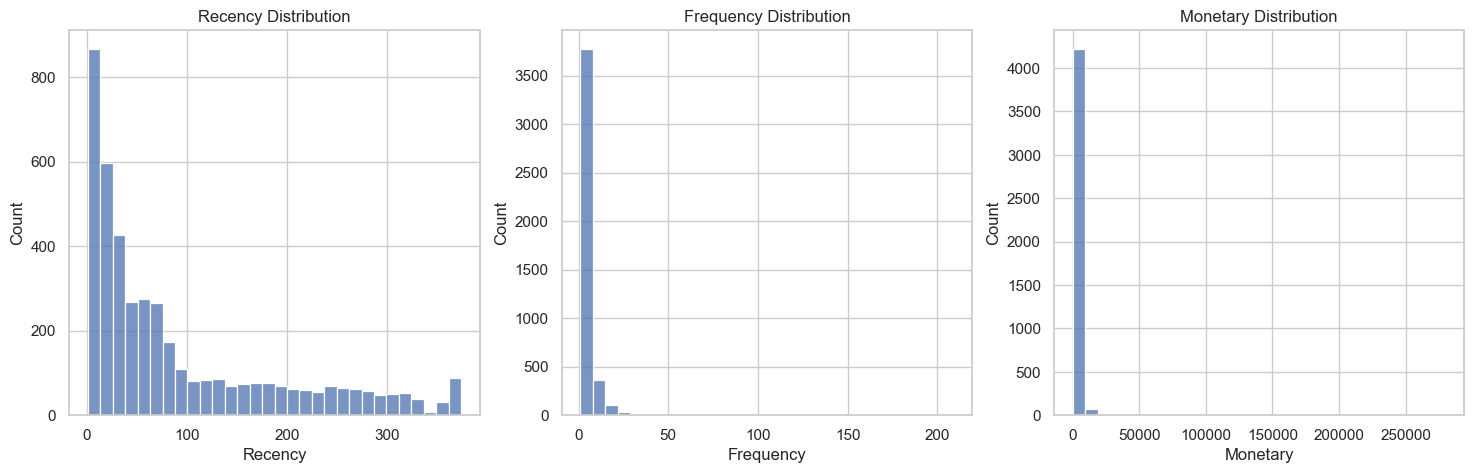

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(rfm['Recency'], bins=30, kde=False, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm['Frequency'], bins=30, kde=False, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm['Monetary'], bins=30, kde=False, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.show()


* Most customers purchased long ago (high Recency).
* Frequency distribution shows many customers only buy once or twice.
* Monetary distribution is skewed — a few customers spend a lot (Pareto principle: 20% bring most revenue).

**Segment Counts**

C:\Users\PMLS\AppData\Local\Temp\ipykernel_19296\360852853.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette="viridis")


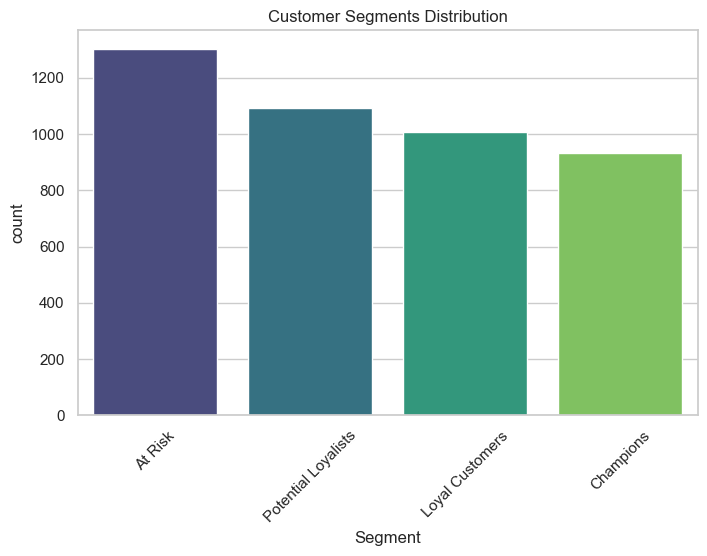

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index, palette="viridis")
plt.title("Customer Segments Distribution")
plt.xticks(rotation=45)
plt.show()


Customers are segmented into four main groups:

* Champions → High overall score, best customers.
* Loyal Customers → Regular buyers with strong frequency.
* Potential Loyalists → Customers showing promise, need nurturing.
* At Risk → Customers disengaging, need recovery campaigns.

This segmentation gives us actionable customer groups.

**Heatmap of RFM Averages**

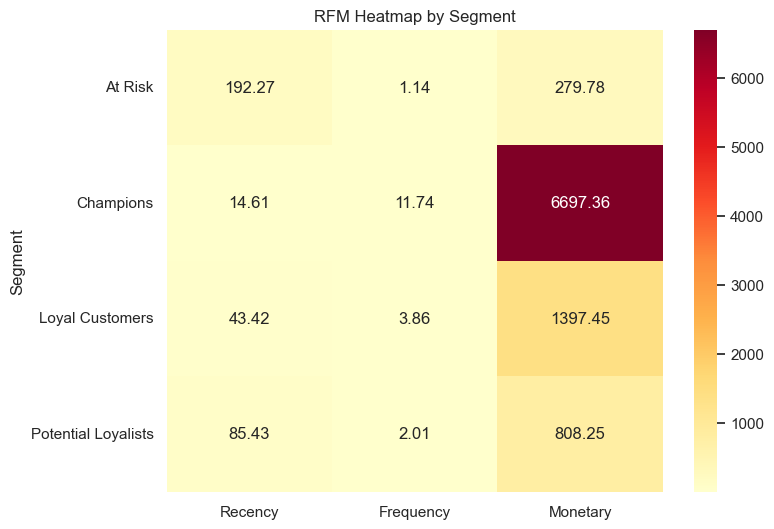

In [16]:
plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("RFM Heatmap by Segment")
plt.show()


The heatmap highlights differences between segments:

* Champions → Low recency, high frequency, high monetary.
* At Risk → High recency, low frequency, low monetary.
* Loyal Customers → Mid recency, strong frequency.
* Potential Loyalists → Recently active but not yet frequent or high-spending.

**Step 8: Insights & Marketing Strategy**

* Champions (RFM ≥ 13) → High frequency & spending, recent activity. Reward with loyalty programs, exclusive offers.
* Loyal Customers (10–12) → Consistent buyers. Upsell & cross-sell with premium products.
* Potential Loyalists (7–9) → New but promising. Provide discounts & targeted campaigns to build loyalty.
* At Risk (<7) → Haven’t purchased recently. Win-back campaigns, personalized offers.

**Step 9: Conclusion**

RFM analysis allowed us to segment customers into meaningful groups.
By targeting each segment with personalized strategies, businesses can:

* Improve retention
* Increase revenue
* Build stronger customer relationships